In [2]:
import pandas as pd
import numpy as np

In [54]:
df = pd.read_csv('dataset/kaggle/cardio_train.csv', sep=';', index_col=0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [55]:
X = df.drop('cardio', axis=1)
y = df['cardio']

In [5]:
y[y==0]

id
0        0
4        0
8        0
9        0
13       0
        ..
99979    0
99981    0
99988    0
99993    0
99999    0
Name: cardio, Length: 35021, dtype: int64

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Use test_size=0.5 to ensure Shadow and Target models have the same amount of training data
# Use stratify to maintain class distribution consistency
target_member_X, shadow_X, target_member_y, shadow_y = train_test_split(X, y, test_size=0.66, random_state=42,)
shadow_X, target_non_X, shadow_y, target_non_y = train_test_split(shadow_X, shadow_y, test_size=0.5, random_state=42)

print(f"Size of target set: {len(target_member_X)}")
print(f"Size of shadow set: {len(shadow_X)}")
print(f"Size of target member set: {len(target_member_X)}")
print(f"Size of target non-member set: {len(target_non_X)}")

Size of target set: 23800
Size of shadow set: 23100
Size of target member set: 23800
Size of target non-member set: 23100


In [53]:
# from sklearn.metrics import accuracy_score
# from xgboost import XGBClassifier

# model_target = XGBClassifier(
#     n_estimators=100,
#     max_depth=10,
#     learning_rate=0.5,
#     min_child_weight=1,
#     subsample = 1.0,
#     eval_metric='logloss',
#     random_state=42)
# model_target.fit(target_member_X, target_member_y)

# # Check Target Model Overfitting
# train_acc = accuracy_score(target_member_y, model_target.predict(target_member_X))
# test_acc = accuracy_score(target_non_y, model_target.predict(target_non_X))
# print(f"Target Model Train Accuracy: {train_acc:.2f}")
# print(f"Target Model Test Accuracy: {test_acc:.2f}")
# print(f"Overfitting Gap: {(train_acc - test_acc):.2f}")

Target Model Train Accuracy: 0.96
Target Model Test Accuracy: 0.69
Overfitting Gap: 0.26


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

# Define a function to create an overfitting neural network using sklearn
def create_overfitting_nn():
    return MLPClassifier(hidden_layer_sizes=(256, 256, 256, 256), activation='relu', solver='adam', max_iter=1000, random_state=42, early_stopping=False)

model_target = create_overfitting_nn()
model_target.fit(target_member_X, target_member_y)

# Check Target Model Overfitting
train_acc = accuracy_score(target_member_y, model_target.predict(target_member_X))
test_acc = accuracy_score(target_non_y, model_target.predict(target_non_X))
print(f"Target Model Train Accuracy: {train_acc:.2f}")
print(f"Target Model Test Accuracy: {test_acc:.2f}")
print(f"Overfitting Gap: {(train_acc - test_acc):.2f}")

Training shadow models

In [ ]:
from sklearn.base import clone

# Train k Random Forest Classifier
K = 32
confidence_df = pd.DataFrame(columns=['prob_0', 'prob_1', 'mem', 'pred_label'])
for i in range(K):
    # Increased complexity (n_estimators) and set large max_depth to encourage overfitting
    # Note: In XGBoost, max_depth=None defaults to 6, which limits overfitting. We set it to 30.
    # Overfitting is necessary for Membership Inference Attacks to distinguish members from non-members
    shadow_member_X, shadow_non_X, shadow_member_y, shadow_non_y = train_test_split(shadow_X, shadow_y, test_size=0.5, shuffle=True, stratify=shadow_y)
    
    # Create a new overfitting neural network for each shadow model
    model = create_overfitting_nn()
    
    print(f"Model: {i+1}/{K}")
    model.fit(shadow_member_X, shadow_member_y)
    in_probs = model.predict_proba(shadow_member_X)
    # Get the prediction class from probabilities
    in_preds = np.argmax(in_probs, axis=1)
    out_probs = model.predict_proba(shadow_non_X)
    out_preds = np.argmax(out_probs, axis=1)
    # Add predicted probabilities to confidence dataframe, the in_probs will be labeled as 1 (member) and out_probs as 0 (non-member)
    in_df = pd.DataFrame(in_probs, columns=['prob_0', 'prob_1'])
    in_df['mem'] = 1
    in_df['pred_label'] = in_preds
    confidence_df = pd.concat([confidence_df, in_df], ignore_index=True)
    out_df = pd.DataFrame(out_probs, columns=['prob_0', 'prob_1'])
    out_df['mem'] = 0
    out_df['pred_label'] = out_preds
    confidence_df = pd.concat([confidence_df, out_df], ignore_index=True)

    print(f"Train accuracy: {accuracy_score(shadow_member_y, model.predict(shadow_member_X))}")
    print(f"Test accuracy: {accuracy_score(shadow_non_y, model.predict(shadow_non_X))}")
confidence_df.head()

Model: 1/32


/tmp/ipykernel_321638/2427119988.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  confidence_df = pd.concat([confidence_df, in_df], ignore_index=True)


Train accuracy: 0.9999134199134199
Test accuracy: 0.6374025974025974
Model: 2/32
Train accuracy: 0.9997402597402597
Test accuracy: 0.6338528138528139
Model: 3/32
Train accuracy: 1.0
Test accuracy: 0.6323809523809524
Model: 4/32
Train accuracy: 1.0
Test accuracy: 0.6296969696969696
Model: 5/32
Train accuracy: 0.9999134199134199
Test accuracy: 0.6402597402597403
Model: 6/32
Train accuracy: 1.0
Test accuracy: 0.638008658008658
Model: 7/32
Train accuracy: 0.9999134199134199
Test accuracy: 0.6298701298701299
Model: 8/32
Train accuracy: 0.9998268398268398
Test accuracy: 0.6271861471861472
Model: 9/32
Train accuracy: 0.9999134199134199
Test accuracy: 0.6384415584415585
Model: 10/32
Train accuracy: 0.9998268398268398
Test accuracy: 0.6338528138528139
Model: 11/32
Train accuracy: 1.0
Test accuracy: 0.6354978354978355
Model: 12/32
Train accuracy: 0.9999134199134199
Test accuracy: 0.6346320346320347
Model: 13/32
Train accuracy: 0.9998268398268398
Test accuracy: 0.6406060606060606
Model: 14/32
Tra

,prob_0,prob_1,mem,pred_label
0,1.0,0.0,1,0
1,0.0,1.0,1,1
2,0.0,1.0,1,1
3,1.0,0.0,1,0
4,1.0,0.0,1,0


In [48]:
confidence_df[confidence_df["mem"] == 0]

,prob_0,prob_1,mem,pred_label
11550,0.0,1.0,0,1
11551,1.0,0.0,0,0
11552,0.0,1.0,0,1
11553,1.0,0.0,0,0
11554,0.0,1.0,0,1
...,...,...,...,...
739195,0.0,1.0,0,1
739196,0.0,1.0,0,1
739197,1.0,0.0,0,0
739198,1.0,0.0,0,0


In [49]:
# Train a attack model using the confidence scores
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

attack_models = {}

for i in range(2): # Two attack models: one for each class
    _df = confidence_df[confidence_df['pred_label'] == i]
    attack_X = _df[['prob_0', 'prob_1']]
    attack_y = _df['mem'].astype('int')

    attack_X_train, attack_X_test, attack_y_train, attack_y_test = train_test_split(attack_X, attack_y, test_size=0.5, random_state=42, shuffle=True)

    # Using XGBClassifier as it is generally more powerful for this type of tabular data
    attack_model = XGBClassifier(eval_metric='logloss')
    attack_model.fit(attack_X_train, attack_y_train)
    attack_y_pred = attack_model.predict(attack_X_test)
    attack_models[i] = attack_model
    print(f"Attack Model for class {i}")
    print("- Attack Model Performance:")
    print(classification_report(attack_y_test, attack_y_pred))

Attack Model for class 0
- Attack Model Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     92777
           1       0.65      0.00      0.00     92642

    accuracy                           0.50    185419
   macro avg       0.58      0.50      0.33    185419
weighted avg       0.58      0.50      0.33    185419

Attack Model for class 1
- Attack Model Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66     91741
           1       0.00      0.00      0.00     92440

    accuracy                           0.50    184181
   macro avg       0.25      0.50      0.33    184181
weighted avg       0.25      0.50      0.33    184181



/home/chau-an-phu/Projects/CVD/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/chau-an-phu/Projects/CVD/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/chau-an-phu/Projects/CVD/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [ ]:
# Test on the target model
# Added stratify=target_y
# Use same overfitting parameters as shadow models

in_probs = predict_proba_nn(model_target, target_member_X.values)
in_preds = np.argmax(in_probs, axis=1)
out_probs = predict_proba_nn(model_target, target_non_X.values)
out_preds = np.argmax(out_probs, axis=1)
# Add predicted probabilities to confidence dataframe, the in_probs will be labeled as 1 (member) and out_probs as 0 (non-member)
in_df = pd.DataFrame(in_probs, columns=['prob_0', 'prob_1'])
in_df['mem'] = 1
in_df['pred_label'] = in_preds
# Fixed column name 'label' -> 'mem'
confidence_df = pd.DataFrame(columns=['prob_0', 'prob_1', 'mem', 'pred_label'])
confidence_df = pd.concat([confidence_df, in_df], ignore_index=True)
out_df = pd.DataFrame(out_probs, columns=['prob_0', 'prob_1'])
out_df['mem'] = 0
out_df['pred_label'] = out_preds
confidence_df = pd.concat([confidence_df, out_df], ignore_index=True)
attack_X = confidence_df[['prob_0', 'prob_1']]
attack_y = confidence_df['mem'].astype('int')

for i in range(2):
    attack_model = attack_models[i]
    attack_X_class = attack_X[confidence_df['pred_label'] == i]
    attack_y_class = attack_y[confidence_df['pred_label'] == i]
    print(f"Attack Model on Target Model for class {i}")
    print("- Attack Model Performance:")
    attack_y_pred = attack_model.predict(attack_X_class)
    print(classification_report(attack_y_class, attack_y_pred))

Attack Model on Target Model for class 0
- Attack Model Performance:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65     11257
           1       0.00      0.00      0.00     11967

    accuracy                           0.48     23224
   macro avg       0.24      0.50      0.33     23224
weighted avg       0.23      0.48      0.32     23224

Attack Model on Target Model for class 1
- Attack Model Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11843
           1       0.00      0.00      0.00     11833

    accuracy                           0.50     23676
   macro avg       0.25      0.50      0.33     23676
weighted avg       0.25      0.50      0.33     23676



/tmp/ipykernel_321638/2598122893.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  confidence_df = pd.concat([confidence_df, in_df], ignore_index=True)
/home/chau-an-phu/Projects/CVD/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/chau-an-phu/Projects/CVD/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

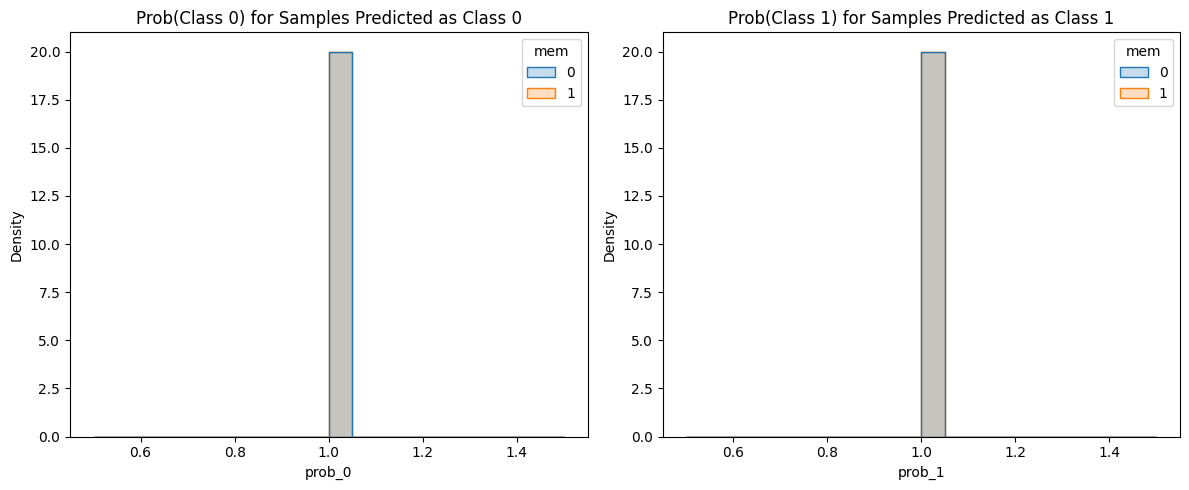

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the probability distribution for members vs non-members
# We look at the probability of the predicted class
# For class 0 predictions, we look at prob_0
# For class 1 predictions, we look at prob_1

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
data_class_0 = confidence_df[confidence_df['pred_label'] == 0]
sns.histplot(data=data_class_0, x='prob_0', hue='mem', element='step', stat='density', common_norm=False, bins=20)
plt.title('Prob(Class 0) for Samples Predicted as Class 0')

plt.subplot(1, 2, 2)
data_class_1 = confidence_df[confidence_df['pred_label'] == 1]
sns.histplot(data=data_class_1, x='prob_1', hue='mem', element='step', stat='density', common_norm=False, bins=20)
plt.title('Prob(Class 1) for Samples Predicted as Class 1')

plt.tight_layout()
plt.show()

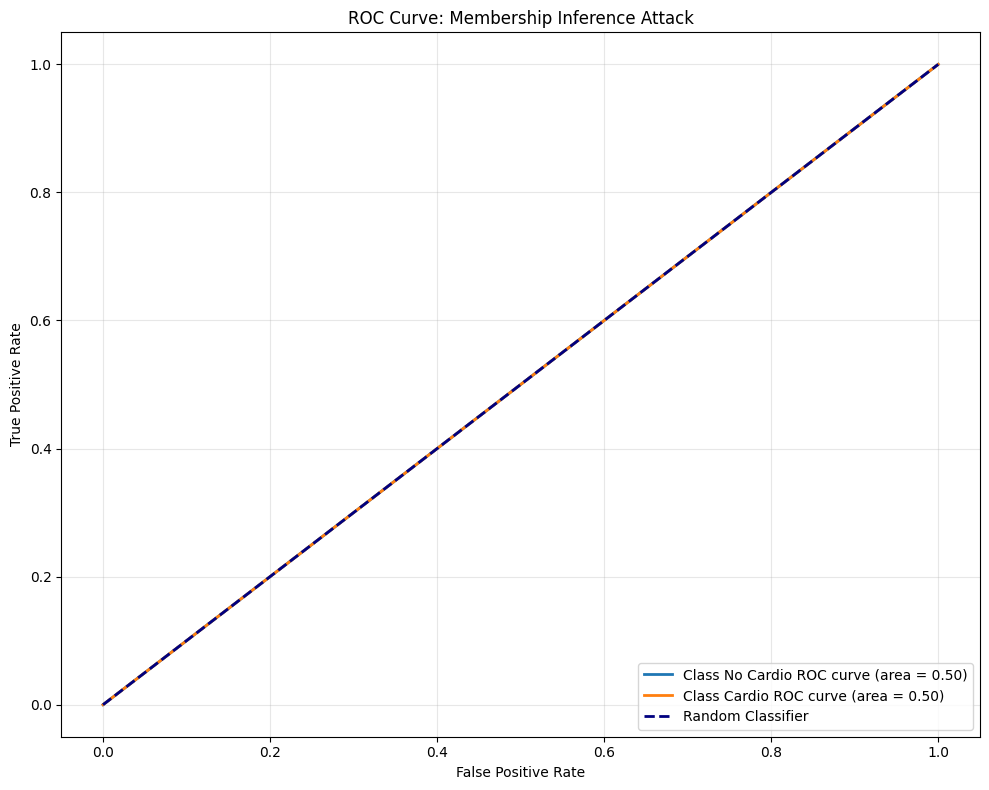

In [52]:

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
classes = {
    0: 'No Cardio',
    1: 'Cardio',
}
for i in range(2):
    attack_model = attack_models[i]
    attack_X_class = attack_X[confidence_df['pred_label'] == i]
    attack_y_class = attack_y[confidence_df['pred_label'] == i]
    
    # Get predicted probabilities
    attack_y_proba = attack_model.predict_proba(attack_X_class)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(attack_y_class, attack_y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
# plt.xlim([1e-4, 0.1])
# plt.ylim([1e-4, 1.0])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Membership Inference Attack')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
